## Analysis of Voter Turnout and Demographic Influence in New York State

### Introduction
This notebook contains synthetic data aimed at analyzing voter turnout across different counties in New York State and understanding the demographic factors such as age, income and education level that influence voting behavior. Find more details on my [github.](https://github.com/danielamartinezli/voter_turnout_nys)
___

### Importing libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
# Generating synthetic data

def syn_data (n=1000):
    np.random.seed(43)
    data = pd.DataFrame({
        'county': np.random.choice(['Albany', 'Bronx', 'Kings', 'Queens'], n),
        'age' : np.random.randint(18,90,n),
        'income': np.random.normal(50000, 15000, n).astype(int),
        'Unemployment_Rate': np.random.uniform(2, 10, n),
        'education': np.random.choice(['High School', 'Bachelor', 'Master'], n),
        'voted': np.random.binomial(1, 0.6, n)  # 1 for voted, 0 for not voted
    })

    demo_df = pd.DataFrame(data)
    return demo_df

# Adding data to variable
voter_df = syn_data()

# Saving as csv
voter_df.to_csv('voter_data.csv', index=False)

# Checking
voter_df.head()


,county,age,income,Unemployment_Rate,education,voted
0,Albany,77,28664,4.441681,High School,1
1,Albany,79,48870,7.153066,Bachelor,0
2,Queens,37,66351,2.435459,Bachelor,1
3,Bronx,66,46096,6.554092,Master,0
4,Bronx,40,79517,9.914037,Master,1


### ETL Process

In [63]:
# Cleaning df
# Count the total number of duplicated rows
total_duplicates = voter_df.duplicated().sum()

# Calculate the total number of rows
total_rows = voter_df.shape[0]

# Calculate the percentage of duplicate entries
percentage_duplicates = (total_duplicates / total_rows) * 100

# Print the percentage of duplicate entries
print("Percentage of duplicate entries:", percentage_duplicates)

Percentage of duplicate entries: 0.0


### Exploratory Data Analysis

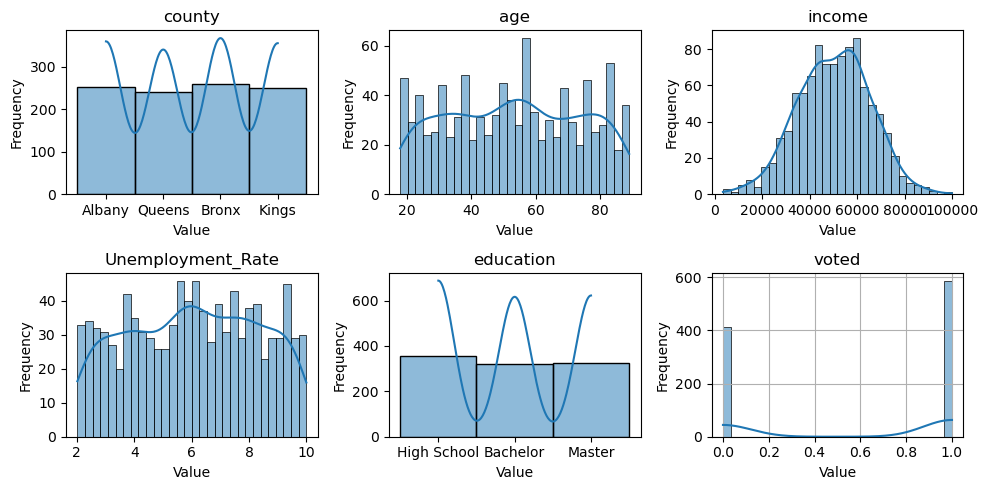

In [64]:
# Checking data distribution
plt.subplots(2,3, figsize = (10,5))

# Create histograms for each column
for plot_num, col in enumerate(voter_df.columns, 1):
    plt.subplot(2, 3, plot_num)
    sns.histplot(voter_df[col], bins=30, kde=True)  # Replace with appropriate bin count and KDE as needed
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.grid(True)
plt.show()


Voter participation, age, and unemployment rate display a uniform distribution, income has a normal distribution, and the 'voted' variable is bimodal due to the nature of its data.

In [65]:
voter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             1000 non-null   object 
 1   age                1000 non-null   int32  
 2   income             1000 non-null   int32  
 3   Unemployment_Rate  1000 non-null   float64
 4   education          1000 non-null   object 
 5   voted              1000 non-null   int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 35.3+ KB


In [66]:
# Basic EDA summary
print(f"Total rows: {voter_df.shape[0]}")
print(f"Total columns: {voter_df.shape[1]}")
print(f"Null values: {voter_df.isna().sum().sum()}")
print(f'----------')
print (f"Duplicate columns: {voter_df.T.duplicated()}")

Total rows: 1000
Total columns: 6
Null values: 0
----------
Duplicate columns: county               False
age                  False
income               False
Unemployment_Rate    False
education            False
voted                False
dtype: bool


In [67]:
def explore_data(voter_df):
    print(voter_df.describe())
    voter_df['voted'].value_counts().plot(kind='bar', title='Voter Turnout')
    plt.show()

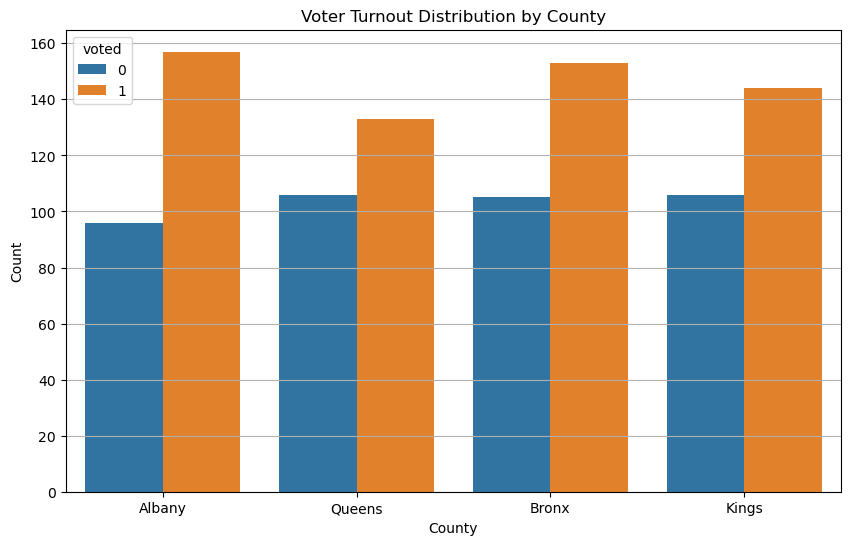

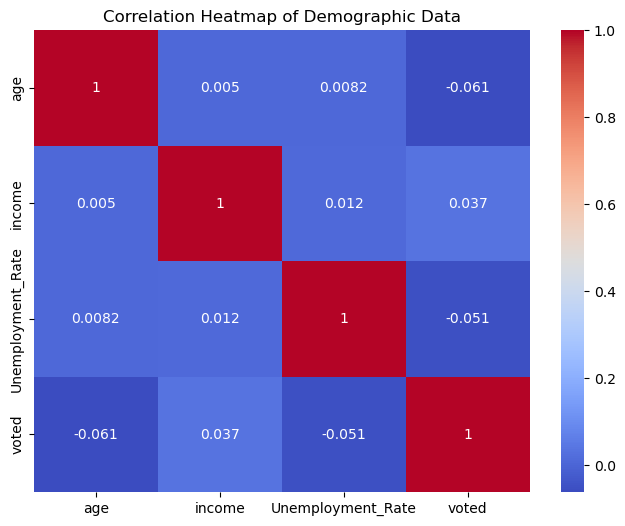

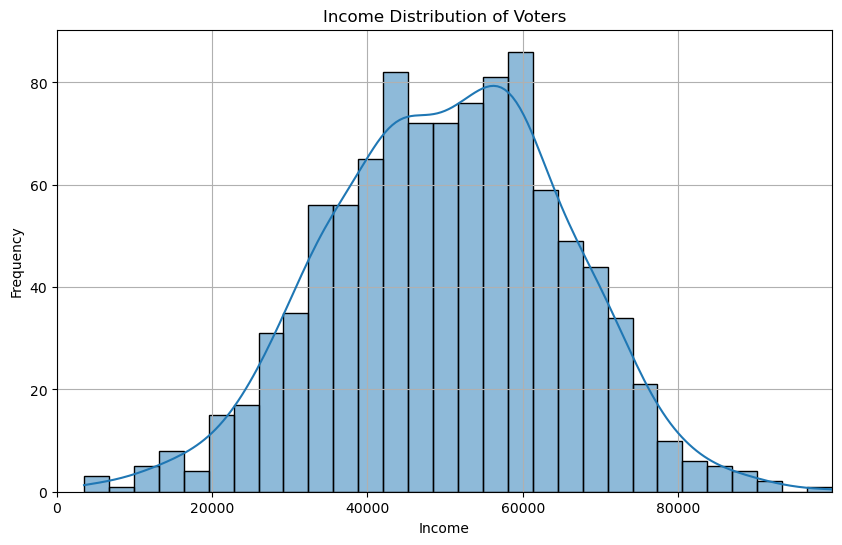

In [68]:
# Plot voter turnout distribution by county
plt.figure(figsize=(10, 6))
plt.grid()
sns.countplot(x='county', hue='voted', data=voter_df)
plt.title('Voter Turnout Distribution by County')
plt.xlabel('County')
plt.ylabel('Count')
plt.show()

# Correlation heatmap for demographic data
plt.figure(figsize=(8, 6))
sns.heatmap(voter_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Demographic Data')
plt.show()

# Distribution of Income
plt.figure(figsize=(10, 6))
plt.grid(True)
sns.histplot(voter_df['income'], bins=30, kde=True)
plt.title('Income Distribution of Voters')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.xlim(0, voter_df['income'].max())

plt.show()

In general, voter participation was higher than abstention, with notably higher participation in Albany.

Citizens with incomes between $30,000 and $70,000 showed higher participation rates.

Age and unemployment rate had the highest correlations with voting.

### Predictive Modeling

In [69]:
voter_df.columns

Index(['county', 'age', 'income', 'Unemployment_Rate', 'education', 'voted'], dtype='object')

In [70]:
# Feature engineering
voter_df['education'] = voter_df['education'].map({'High School': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3})
X = voter_df[['age', 'income', 'education']]
y = voter_df['voted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.02      0.03       119
           1       0.61      0.99      0.75       181

    accuracy                           0.61       300
   macro avg       0.64      0.51      0.39       300
weighted avg       0.63      0.61      0.47       300



This model struggled with classifying Class 0, as indicated by the low recall, which points to a high number of false negatives for this class. In contrast, it performed well in predicting Class 1, achieving a recall of 0.99. The overall accuracy is moderate at 61%, but performance varies significantly between the two classes.

Based on these results, it is essential to adjust the dataset to be more balanced using class weights and resampling techniques. Additionally, implementing models that handle class imbalance, such as Random Forest or Gradient Boosting (XGBoost), could help reduce variance in predictions and improve classification performance.